Installations + versions of keras and tensorflow, we use python 3.10.6 as kernel

In [ ]:

%pip install tensorflow==2.11.0
%pip install keras==2.11.0
%pip install matplotlib
%pip install numpy
%pip install scikit-learn
%pip install opencv-python

this file loads the images and adds labels, returns the x_combined and y_combined

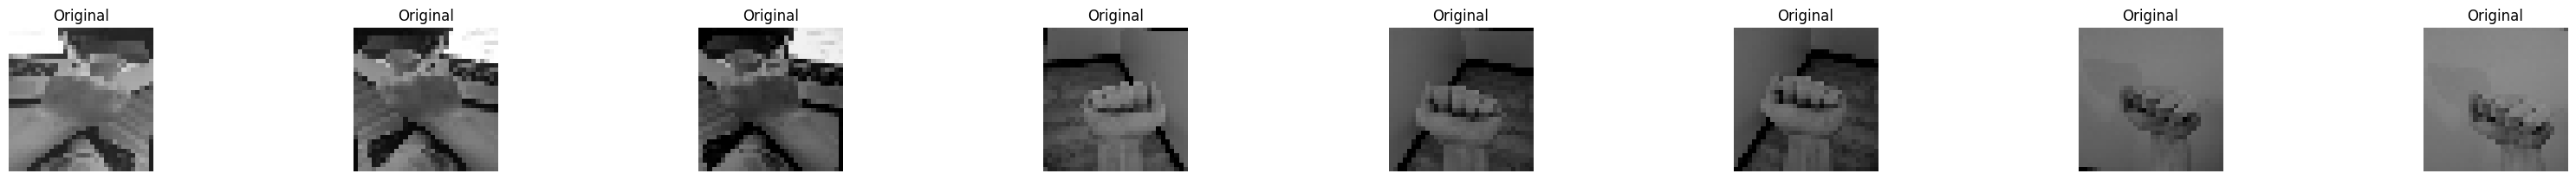

In [ ]:

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# change this to your image folder when grading
main_dir = 'C://Users//tijnh//Documents//mod8//new_data'

# processes the images
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (32, 32))
    image = image / 255.0
    image = np.stack((image,) * 3, axis=-1)
    return image

# loads everything inside the folder into images and labels
def load_images_and_labels(main_dir):
    images = []
    labels = []

    for subdir in ['train', 'valid']:
        subdir_path = os.path.join(main_dir, subdir)
        image_filenames = [f for f in os.listdir(subdir_path) if f.endswith(".jpg") or f.endswith(".png")]

        for filename in sorted(image_filenames):
            image_path = os.path.join(subdir_path, filename)
            image = preprocess_image(image_path)
            images.append(image)
            label = ord(filename[0].upper()) - ord('A')  # Convert 'A' -> 0, 'B' -> 1, ...
            labels.append(label)

    return np.array(images), np.array(labels).reshape(-1, 1)

# visualizes the images, only used for testing
def visualize_images(images, num_images):
    plt.figure(figsize=(num_images * 4, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Load images and labels
x_combined, y_combined = load_images_and_labels(main_dir)

# Visualize some of the images
visualize_images(x_combined, 8)




This file splits the images into val and train data, we don't split into test samples since we use a separate file for that

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# set percentages, we dont split it into test set since we have a separate folder we use for testing.
total_samples = x_combined.shape[0]
num_test = int(0 * total_samples)
num_val = int(0.2 * total_samples)
num_train = total_samples - num_test - num_val

# Shuffle the dataset
indices = np.arange(total_samples)
np.random.shuffle(indices)

x_combined_shuffled = x_combined[indices]
y_combined_shuffled = y_combined[indices]

# Split the dataset
x_test = x_combined_shuffled[:num_test]
y_test = y_combined_shuffled[:num_test]

x_val = x_combined_shuffled[num_test:num_test + num_val]
y_val = y_combined_shuffled[num_test:num_test + num_val]

x_train = x_combined_shuffled[num_test + num_val:]
y_train = y_combined_shuffled[num_test + num_val:]

# Ensure the shapes
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# fit hot encoded
y_train = tf.keras.utils.to_categorical(y_train, num_classes=26)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=26)


The following file trains the model to be then used for pruning, it gets a lower accuracy but the model size is also low enough to be uploaded onto the arduino

In [ ]:
import json
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Dense, Input, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# creates the model
def create_model():
    model = tf.keras.models.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(26, activation='softmax'))

    return model

with tf.device('/device:GPU:0'):
    model = create_model()

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


    datagen = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    )

    datagen.fit(x_train)

    batch_size = 64
    epochs = 300

    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=len(x_train) // batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val))

    # save the model, set it to the name you want to use it on.
    tf.keras.models.save_model(model, 'final_5_layered2')

    model.save_weights('final_model.h5')


    with open('training_history.json', 'w') as f:
        json.dump(history.history, f)

    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

The following file trains the model for accuracy, but it results in a lot bigger size

In [ ]:
import json
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Dense, Input, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

def create_model():
    model = tf.keras.models.Sequential([
        Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Conv2D(64, (5, 5), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(26, activation='softmax')
    ])
    return model



data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.05),
    RandomZoom(0.02, 0.02),
    RandomTranslation(0.0001, 0.0001),
    RandomBrightness(0.00001),
    RandomContrast(0.00001),
    tf.keras.layers.Lambda(lambda img: tf.image.random_jpeg_quality(img, 75, 100) if tf.random.uniform(()) < 0.1 else img)
])


with tf.device('/device:GPU:0'):
    model = create_model()

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


    batch_size = 16
    epochs = 700


    datagen = ImageDataGenerator(preprocessing_function=lambda img: data_augmentation(img, training=True))

    datagen.fit(x_train)

    def visualize_augmentations(datagen, images, num_images=5):
        plt.figure(figsize=(num_images * 4, 4))
        for i in range(num_images):
            ax = plt.subplot(2, num_images, i + 1)
            plt.imshow(images[i])
            plt.title("Original")
            plt.axis("off")

            augmented_image = next(datagen.flow(np.expand_dims(images[i], axis=0), batch_size=1))[0]
            ax = plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(augmented_image)
            plt.title("Augmented")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    visualize_augmentations(datagen, x_train, num_images=5)

    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=len(x_train) // batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val))

    # Save the model and training history
    tf.keras.models.save_model(model, 'final_5_layered2')
    model.save_weights('final_model.h5')

    with open('training_history.json', 'w') as f:
        json.dump(history.history, f)

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


This file is used for testing, it loads the test data and makes predictions using our model

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt


loaded_model = tf.keras.models.load_model('final_5_layered2')

input_key = list(loaded_model.signatures["serving_default"].structured_input_signature[1].keys())[0]
print(f"Input key: {input_key}")

class_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
               'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
               'u', 'v', 'w', 'x', 'y', 'z']

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (32, 32))
    image = image / 255.0
    image = np.stack((image,) * 3, axis=-1)
    image = np.expand_dims(image, axis=0)
    return image

def predict_image_label(file_path):
    img_array = preprocess_image(file_path)

    infer = loaded_model.signatures["serving_default"]

    predictions = infer(tf.constant(img_array, dtype=tf.float32))

    output_key = list(predictions.keys())[0]
    predicted_class = np.argmax(predictions[output_key][0])
    predicted_label = class_names[predicted_class]
    return predicted_label

def predict_labels_in_folder(folder_path):
    predicted_labels = []
    actual_labels = []
    predicted_labels_dict = {chr(i): [] for i in range(ord('a'), ord('z') + 1)}
    actual_labels_dict = {chr(i): [] for i in range(ord('a'), ord('z') + 1)}
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, filename)
                predicted_label = predict_image_label(file_path)
                actual_label = filename[0].lower()#ord(filename[0].upper())- ord('A')

                if actual_label in predicted_labels_dict:  # Ensure it's a valid letter
                        predicted_labels_dict[actual_label].append(predicted_label)
                        actual_labels_dict[actual_label].append(actual_label)

                print(f"{actual_label}                {predicted_label}")

    accuracy_dict = {}
    for letter in predicted_labels_dict:
        if predicted_labels_dict[letter]:
            predicted_labels = np.array(predicted_labels_dict[letter])
            actual_labels = np.array(actual_labels_dict[letter])
            accuracy_dict[letter] = accuracy_score(actual_labels, predicted_labels)
    accuracies = []
    for letter, accuracy in accuracy_dict.items():
        accuracies.append(accuracy)
        length = len(predicted_labels_dict[letter])
        print(f"{letter} | {accuracy} | {length}")

    print(f"Final accuracy: {np.mean(accuracies)}")

def visualize_augmentations(images, num_images):
    plt.figure(figsize=(num_images * 4, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# change to your test folder
folder_path = 'C://Users//tijnh//Documents//mod8//new_data//test'
predict_labels_in_folder(folder_path)
